In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the data
!unzip /content/drive/MyDrive/HAM10000_seperated.zip -d /content/

Archive:  /content/drive/MyDrive/HAM10000_seperated.zip
   creating: /content/HAM10000_seperated/
   creating: /content/HAM10000_seperated/akiec/
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024329.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024372.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024418.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024450.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024463.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024468.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024470.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024511.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024517.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024522.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024539.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024562.jpg  
  inflating: /content/HAM10000_seperated/akiec/ISIC_0024575.jp

In [ ]:
!pip install --upgrade transformers datasets evaluate timm scikit-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 141.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: agarwal-arpitaa9 (agarwal-arpitaa9-indian-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import evaluate
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
    EarlyStoppingCallback,
    set_seed,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
MODEL_CHECKPOINT = "microsoft/swin-base-patch4-window7-224"
DATA_DIR = "/content/HAM10000_seperated" # The path where we unzipped our data
OUTPUT_DIR = "/content/drive/MyDrive/swin-finetuned-skincancer"
NUM_LABELS = 7 # 7 classes
BATCH_SIZE = 16
SEED = 42
EPOCHS = 10 # Start with a few epochs to see how it goes

In [ ]:
print("Loading and splitting the dataset...")
# Load the entire dataset from the folders
full_dataset = load_dataset("imagefolder", data_dir=DATA_DIR)

# The loaded dataset likely only has a 'train' split. We need to split this into
# training, validation, and test sets.
# First, split the 'train' set into a combined train/validation set and a test set (e.g., 80/20 split)
train_val_split = full_dataset['train'].train_test_split(test_size=0.2, seed=SEED)

# Then, split the combined train/validation set into separate training and validation sets (e.g., 80/20 split of the 80%)
train_split = train_val_split['train'].train_test_split(test_size=0.2, seed=SEED)

# Create a new DatasetDict with the correct splits: train, validation, and test
dataset = DatasetDict({
    'train': train_split['train'],       # 80% of 80% of original train set for training
    'validation': train_split['test'],   # 20% of 80% of original train set for validation
    'test': train_val_split['test']      # 20% of original train set for final testing
})
print("Dataset successfully split:")
print(dataset)

Loading and splitting the dataset...


Resolving data files:   0%|          | 0/2584 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset successfully split:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1653
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 414
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 517
    })
})


In [ ]:
labels = dataset["train"].features["label"].names
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)

def transform(examples):
    inputs = image_processor(examples["image"], return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs
processed_dataset = dataset.with_transform(transform)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True, # This is crucial
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    report_to="wandb",  # Tell the trainer to log results to W&B
    run_name="swin-baseline-finetune_f",
    logging_steps=10,
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)




In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"], # Use the new validation set for evaluation
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

print("Starting baseline model training...")
trainer.train()
print("Training finished!")

/tmp/ipython-input-3109972461.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting baseline model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.962800,0.849838,0.678744,0.673265
2,0.681300,0.526892,0.818841,0.817293
3,0.361000,0.516385,0.814010,0.811235
4,0.060600,0.643317,0.814010,0.811445
5,0.073300,0.724955,0.833333,0.830957
6,0.023600,0.840047,0.852657,0.848021
7,0.000500,0.797053,0.845411,0.845339
8,0.000200,0.782410,0.859903,0.858824
9,0.000100,0.815188,0.864734,0.863900
10,0.000200,0.808832,0.862319,0.861098


Training finished!



Performing final evaluation on the unseen hold-out test set...



--- Final Test Set Metrics ---
Test Accuracy: 0.8182
Test F1-Score: 0.8187
----------------------------

Generating confusion matrix on the test set...


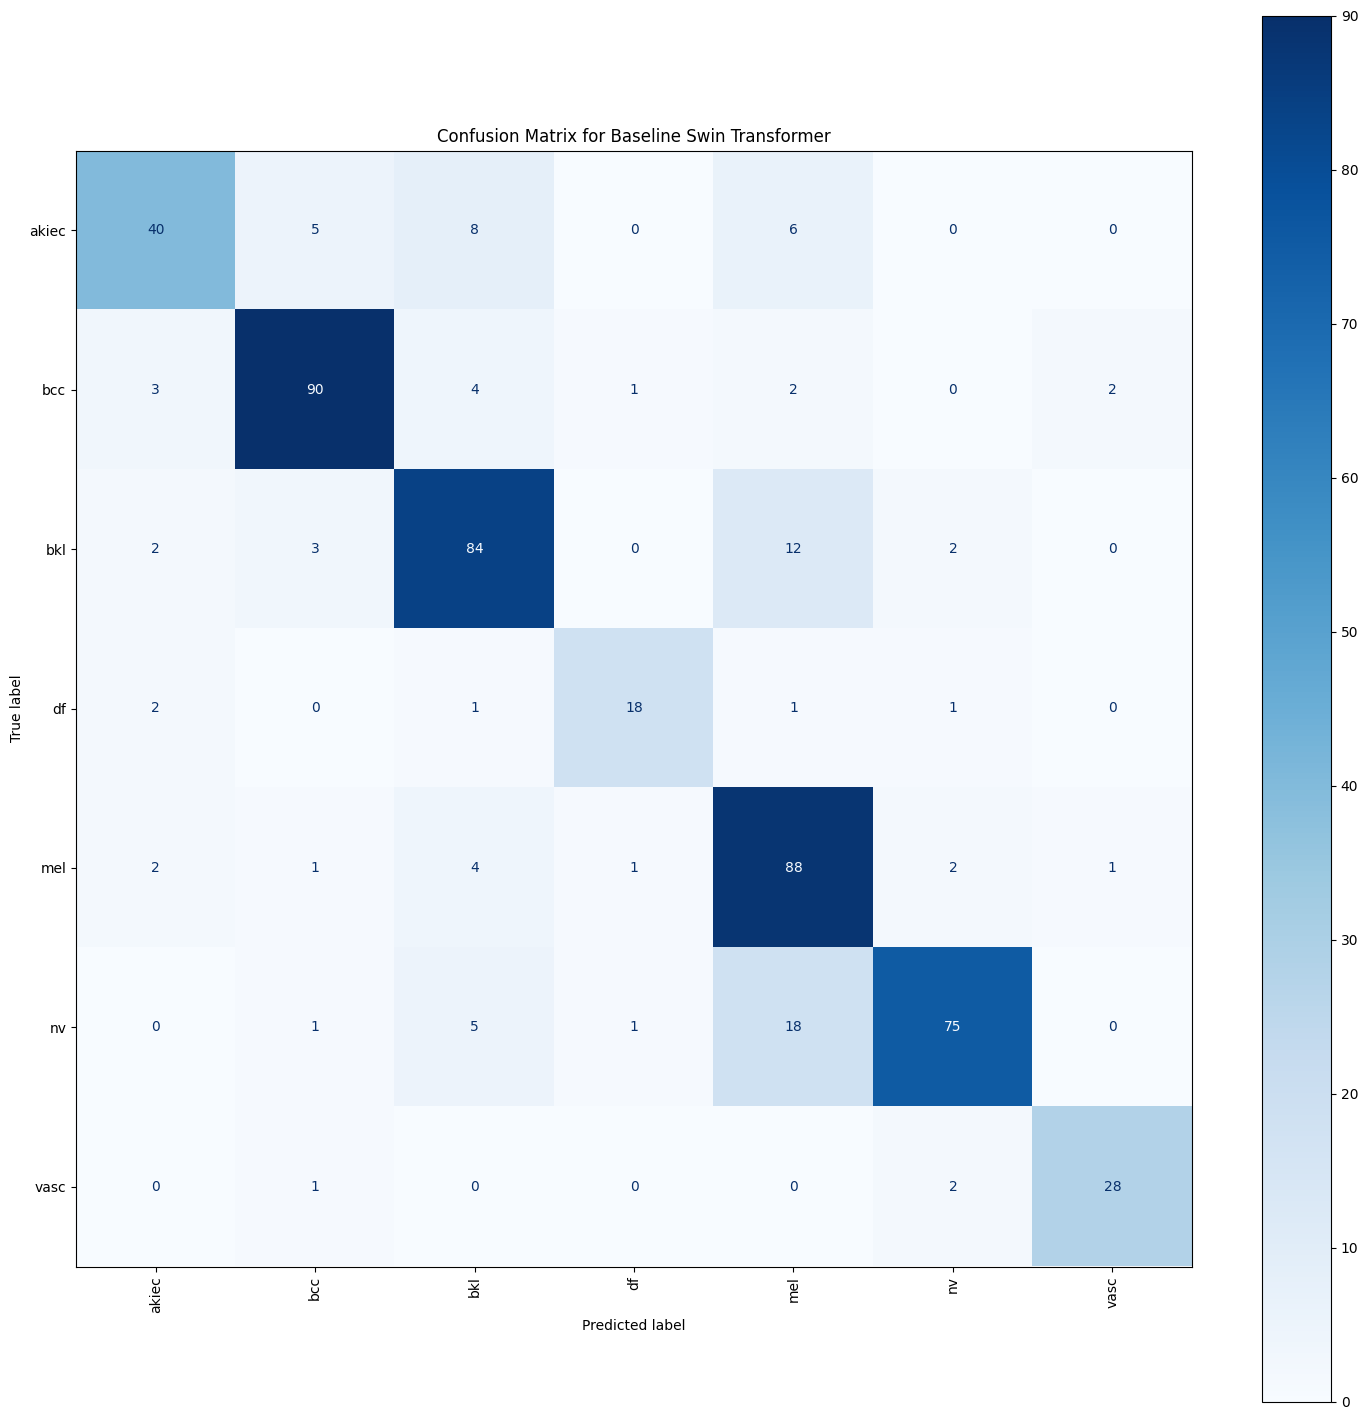

In [ ]:
print("\nPerforming final evaluation on the unseen hold-out test set...")
results = trainer.evaluate(eval_dataset=processed_dataset["test"])

print("\n--- Final Test Set Metrics ---")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test F1-Score: {results['eval_f1']:.4f}")
print("----------------------------\n")

# 12. GENERATE AND PLOT CONFUSION MATRIX
# ----------------------------------------
print("Generating confusion matrix on the test set...")
predictions_output = trainer.predict(processed_dataset["test"])
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids
class_names = dataset["test"].features["label"].names

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix for Baseline Swin Transformer")
plt.show()

INFERENCE



In [ ]:
!ls /content/drive/MyDrive/swin-finetuned-skincancer

checkpoint-104	 checkpoint-208  checkpoint-416  checkpoint-624  checkpoint-832
checkpoint-1040  checkpoint-312  checkpoint-520  checkpoint-728  checkpoint-936


In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image

# 1. SETUP: Define paths and device
# ----------------------------------
# This should be the same directory where your best model was saved
MODEL_PATH = "/content/drive/MyDrive/swin-finetuned-skincancer/checkpoint-520" # Example path: Trainer saves checkpoints in subdirectories
# Upload a new image to Colab and put its path here
IMAGE_PATH = "/content/drive/MyDrive/skin_image.jpeg" # Example path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. LOAD THE FINE-TUNED MODEL AND PROCESSOR
# -------------------------------------------
print(f"Loading model from: {MODEL_PATH}")
# The image processor contains the information about resizing, normalizing, etc.
processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
# Load the model weights you trained
model = AutoModelForImageClassification.from_pretrained(MODEL_PATH).to(device)

# 3. LOAD AND PREPROCESS THE NEW IMAGE
# ------------------------------------
try:
    # Open the image using the Pillow library
    image = Image.open(IMAGE_PATH).convert("RGB")
except FileNotFoundError:
    print(f"Error: Image not found at {IMAGE_PATH}")
    print("Please upload your image to Colab and update the IMAGE_PATH variable.")
    # Stop execution if image is not found
    raise

print("Image loaded successfully. Preprocessing image...")
# Preprocess the image and convert it to PyTorch tensors
# The processor applies all the transformations needed for the model
inputs = processor(images=image, return_tensors="pt").to(device)

# 4. PERFORM INFERENCE
# --------------------
print("Running inference...")
# We use torch.no_grad() to disable gradient calculations, which saves memory and speeds up inference
with torch.no_grad():
    logits = model(**inputs).logits

# 5. GET THE PREDICTION
# ---------------------
# The model outputs raw scores (logits). We find the class with the highest score.
predicted_class_idx = logits.argmax(-1).item()

# Use the model's configuration to map the predicted index back to a readable class name
predicted_class = model.config.id2label[predicted_class_idx]

print("\n--- Prediction Result ---")
print(f"The model predicts this image is: {predicted_class}")

Loading model from: /content/drive/MyDrive/swin-finetuned-skincancer/checkpoint-520
Image loaded successfully. Preprocessing image...
Running inference...

--- Prediction Result ---
The model predicts this image is: nv


In [ ]:
# ====== KAN modules ======
import torch.nn as nn
import torch.nn.functional as F
import math

# FULLY CORRECTED KANLinear CLASS
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features,
                 grid_size=5, spline_order=3,
                 scale_noise=0.01, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True,
                 base_activation=nn.SiLU,
                 grid_eps=0.02, grid_range=[-1,1]):

        super().__init__()
        self.in_features, self.out_features = in_features, out_features
        self.grid_size, self.spline_order = grid_size, spline_order
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1)*h + grid_range[0])
                .expand(in_features, -1).contiguous())
        self.register_buffer('grid', grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))

        # CHANGE #1: Use grid_size + 1 to match the forward pass
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + 1))

        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))
        else:
            self.register_buffer('spline_scaler', torch.tensor(1.0))

        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * (self.scale_base or 1.0))
        with torch.no_grad():
            # CHANGE #2: Use grid_size + 1 here as well
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features, device=self.base_weight.device) - 0.5)
                     * (self.scale_noise) / max(1, self.grid_size))
            init_coeff = noise.permute(2,1,0).contiguous()
            self.spline_weight.data.copy_(init_coeff)
            if hasattr(self, 'spline_scaler') and isinstance(self.spline_scaler, nn.Parameter):
                nn.init.constant_(self.spline_scaler, float(self.scale_spline))

    @property
    def scaled_spline_weight(self):
        if isinstance(self.spline_scaler, nn.Parameter):
            return self.spline_weight * self.spline_scaler.unsqueeze(-1)
        return self.spline_weight

    def forward(self, x):
        orig_shape = x.shape
        x = x.reshape(-1, self.in_features)
        base_out = F.linear(self.base_activation(x), self.base_weight)

        grid = self.grid
        xs = x.unsqueeze(-1)

        knots = grid[:, : self.grid_size+1].unsqueeze(0)

        d = (xs - knots)
        sigma = max(1e-2, float((grid[:,1]-grid[:,0]).abs().mean().item() * 0.5))
        bases = torch.exp(- (d**2) / (2 * (sigma**2)))

        spline_vec = bases.view(x.size(0), -1)
        W = self.scaled_spline_weight.view(self.out_features, -1)
        spline_out = F.linear(spline_vec, W)

        out = base_out + spline_out
        out = out.reshape(*orig_shape[:-1], self.out_features)
        return out

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        reg_act = l1_fake.sum()
        p = l1_fake / (reg_act + 1e-12)
        reg_entropy = - (p * (p + 1e-12).log()).sum()
        return regularize_activation * reg_act + regularize_entropy * reg_entropy

# CORRECTED KANMLP CLASS
class KANMLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features=None,
                 act_layer=nn.GELU, drop=0., use_kan_fc1=True, use_kan_fc2=False, kan_kwargs=None):
        super().__init__()
        out_features = out_features or in_features
        kan_kwargs = kan_kwargs or {}
        self.fc1 = KANLinear(in_features, hidden_features, **kan_kwargs) if use_kan_fc1 else nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        # The original SwinMLP has two dropouts, we keep that structure
        self.drop1 = nn.Dropout(drop)
        self.fc2 = KANLinear(hidden_features, out_features, **kan_kwargs) if use_kan_fc2 else nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x, *args, **kwargs):
        # This signature accepts the main tensor 'x' and ignores any other arguments
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

# def replace_mlp_with_kan(model, use_kan_fc1=True, use_kan_fc2=False, kan_kwargs=None, init_from_linear=True):
#     kan_kwargs = kan_kwargs or {}
#     replaced = 0

#     def set_child_module(root, module_name, new_mod):
#         parts = module_name.split('.')
#         parent = root
#         for p in parts[:-1]:
#             parent = getattr(parent, p)
#         setattr(parent, parts[-1], new_mod)

#     # We iterate over a copy of the module list to allow modification
#     for name, module in list(model.named_modules()):
#         # Target modules that are parents of 'intermediate' and 'output' layers
#         # This is specific to the Hugging Face Swin Transformer implementation
#         # Corrected condition for output dense layer
#         if hasattr(module, 'intermediate') and hasattr(module, 'output'):
#             if hasattr(module.intermediate, 'dense') and hasattr(module.output, 'dense') and isinstance(module.intermediate.dense, nn.Linear):

#                 original_intermediate_dense = module.intermediate.dense
#                 original_output_dense = module.output.dense

#                 # Extract properties from the original layers
#                 in_f = original_intermediate_dense.in_features
#                 hid_f = original_intermediate_dense.out_features
#                 out_f = original_output_dense.out_features

#                 # Check for dropout in the parent module (often named SwinOutput)
#                 dropout_p = 0.0
#                 if hasattr(module.output, 'dropout') and isinstance(module.output.dropout, nn.Dropout):
#                     dropout_p = module.output.dropout.p
#                 elif hasattr(module, 'dropout') and isinstance(module.dropout, nn.Dropout):
#                      dropout_p = module.dropout.p


#                 # Create the new KAN MLP module to replace the entire block
#                 kan_mlp = KANMLP(in_features=in_f, hidden_features=hid_f, out_features=out_f,
#                                  act_layer=nn.GELU, # Swin uses GELU
#                                  drop=dropout_p,
#                                  use_kan_fc1=use_kan_fc1, use_kan_fc2=use_kan_fc2, kan_kwargs=kan_kwargs)

#                 # Copy weights from the original linear layers to the new KAN layers
#                 if init_from_linear:
#                     if use_kan_fc1 and hasattr(kan_mlp.fc1, 'base_weight'):
#                         kan_mlp.fc1.base_weight.data.copy_(original_intermediate_dense.weight.data.clone())
#                     else:
#                         kan_mlp.fc1 = original_intermediate_dense

#                     if use_kan_fc2 and hasattr(kan_mlp.fc2, 'base_weight'):
#                         kan_mlp.fc2.base_weight.data.copy_(original_output_dense.weight.data.clone())
#                     else:
#                         kan_mlp.fc2 = original_output_dense

#                 # Replace the entire parent module (e.g., 'SwinMLP') with our new KANMLP
#                 set_child_module(model, name, kan_mlp)
#                 replaced += 1

#     print(f"[replace_mlp_with_kan] Replaced {replaced} modules.")
#     return model

# ====== NEW, CORRECTED Model Surgery Function ======
def replace_mlp_with_kan(model, use_kan_fc1=True, use_kan_fc2=False, kan_kwargs=None, init_from_linear=True):
    """
    This function now correctly targets the 'dense' layer inside SwinIntermediate modules.
    """
    # We need the specific class name from the transformers library
    from transformers.models.swin.modeling_swin import SwinIntermediate

    replaced_count = 0
    for module in model.modules():
        # Check if the module is an instance of SwinIntermediate
        if isinstance(module, SwinIntermediate):
            if use_kan_fc1:
                # Get the original dimensions
                in_features = module.dense.in_features
                out_features = module.dense.out_features

                # Create the new KANLinear layer
                new_kan_layer = KANLinear(in_features, out_features, **(kan_kwargs or {}))

                # Copy the weights from the original linear layer
                if init_from_linear:
                    new_kan_layer.base_weight.data.copy_(module.dense.weight.data)

                # Replace the old dense layer with the new KAN layer
                module.dense = new_kan_layer
                replaced_count += 1

    # Note: use_kan_fc2 is not implemented in this version as it's more complex
    # and you specified replacing only the first part of the MLP.
    if use_kan_fc2:
        print("Warning: Replacing fc2 with KAN is not supported in this script version.")

    print(f"[replace_mlp_with_kan] Replaced {replaced_count} SwinIntermediate dense layers.")
    return model

In [ ]:
# ====== KAN-aware Trainer that injects small KAN regularization ======
from transformers import Trainer

class KANTrainer(Trainer):

    def __init__(self, *args, kan_regularization_weight=1e-4, **kwargs):
        super().__init__(*args, **kwargs)
        self.kan_reg_w = kan_regularization_weight

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        How the loss is computed by Trainer. By default, all models return the loss
        in the first element.

        Subclass and override this if your model returns something different!
        """
        outputs = model(**inputs)
        loss = outputs.loss if hasattr(outputs, 'loss') else outputs['loss']
        reg = 0.0
        for n, m in model.named_modules():
            if hasattr(m, 'regularization_loss'):
                try:
                    reg = reg + m.regularization_loss(regularize_activation=1.0, regularize_entropy=0.5)
                except Exception:
                    pass

        total_loss = loss + self.kan_reg_w * reg
        return (total_loss, outputs) if return_outputs else total_loss

In [ ]:
# A more robust inspection code to find ALL linear layers
print("Inspecting all Linear layers in the model...")
found_linear_layers = False
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Found Linear Layer: '{name}' with shape (in: {module.in_features}, out: {module.out_features})")
        found_linear_layers = True

if not found_linear_layers:
    print("!!! No nn.Linear layers were found in the model. This is highly unusual. !!!")

# Then call your replacement function
# model = replace_mlp_with_kan(...)

Inspecting all Linear layers in the model...
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.self.query' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.self.key' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.self.value' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.output.dense' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.intermediate.dense' with shape (in: 128, out: 512)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.output.dense' with shape (in: 512, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.1.attention.self.query' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.1.attention.self.key' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.1.attention.self.value' with shape (in: 128, out: 128)
Found Linear Layer: 's

In [ ]:
# ====== Apply replacement (KAN only on fc1) and init from pretrained weights ======

kan_opts = {
    "grid_size": 5, "spline_order": 3,
    "scale_noise": 0.01, "scale_base": 1.0, "scale_spline": 1.0,
    "enable_standalone_scale_spline": True,
    "base_activation": torch.nn.SiLU,
    "grid_eps": 0.02, "grid_range": [-1, 1],
}

model = replace_mlp_with_kan(model, use_kan_fc1=True, use_kan_fc2=False, kan_kwargs=kan_opts, init_from_linear=True)

[replace_mlp_with_kan] Replaced 24 SwinIntermediate dense layers.


In [ ]:
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl

class TrainingStatsCallback(TrainerCallback):
    """
    A custom callback to log detailed training statistics to Weights & Biases,
    including learning rates, gradient norms, and parameter norms for different
    parameter groups.
    """
    def on_step_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: nn.Module, optimizer: torch.optim.Optimizer, **kwargs):
        """
        Event called at the end of a training step.
        """
        # Log only every `logging_steps` to avoid cluttering the logs and slowing down training
        if state.global_step % args.logging_steps == 0:

            # --- 1. Log Learning Rates ---
            # The optimizer has param_groups that store the LR for each part of the model
            if optimizer is not None and hasattr(optimizer, 'param_groups'):
                lr_logs = {}
                for i, group in enumerate(optimizer.param_groups):
                    # We make an assumption about the group order based on how we created them
                    group_name = f"group_{i}"
                    if i == 0: group_name = "spline_params"
                    if i == 1: group_name = "head_params"
                    if i == 2: group_name = "backbone_params" # This group only exists in Stage B
                    lr_logs[f'lr/{group_name}'] = group['lr']
                wandb.log(lr_logs, step=state.global_step)

            # --- 2. Log Gradient and Weight Norms ---
            # This requires iterating through the named parameters of the model
            grad_norms = {"grad_norm/total": 0.0}
            weight_norms = {"weight_norm/total": 0.0}

            param_groups = {
                "spline": [],
                "head": [],
                "backbone": []
            }

            # First, categorize parameters
            for n, p in model.named_parameters():
                if p.grad is None: continue
                if 'spline' in n:
                    param_groups["spline"].append(p)
                elif 'classifier' in n or 'head' in n:
                    param_groups["head"].append(p)
                else:
                    param_groups["backbone"].append(p)

            # Calculate norms for each group
            for name, params in param_groups.items():
                if not params: continue

                # Gradient Norm
                total_grad_norm_group = torch.stack([p.grad.detach().norm(2) for p in params]).norm(2).item()
                grad_norms[f'grad_norm/{name}'] = total_grad_norm_group
                grad_norms["grad_norm/total"] += total_grad_norm_group**2

                # Weight Norm
                total_weight_norm_group = torch.stack([p.detach().norm(2) for p in params]).norm(2).item()
                weight_norms[f'weight_norm/{name}'] = total_weight_norm_group

            grad_norms["grad_norm/total"] = grad_norms["grad_norm/total"]**0.5
            wandb.log(grad_norms, step=state.global_step)
            wandb.log(weight_norms, step=state.global_step)

In [ ]:
# ====== Two-stage training orchestration ======

# Stage A: freeze most parameters, train spline params + head only
for n, p in model.named_parameters():
    p.requires_grad = False

# Unfreeze classifier head params (common naming in HuggingFace models)
for n, p in model.named_parameters():
    if ('classifier' in n) or ('head' in n) or ('label_classifier' in n):
        p.requires_grad = True

# Unfreeze spline-related params
for n, p in model.named_parameters():
    if 'spline' in n or 'spline_weight' in n or 'spline_scaler' in n:
        p.requires_grad = True
    # Allow bias and norm params in head to train
    if ('bias' in n) and (('classifier' in n) or ('head' in n)):
        p.requires_grad = True
    if 'LayerNorm' in n or 'layernorm' in n or 'layer_norm' in n:
        p.requires_grad = True

from torch.optim import AdamW
# param groups for stageA
spline_params = [p for n,p in model.named_parameters() if p.requires_grad and ('spline' in n or 'spline_weight' in n or 'spline_scaler' in n)]
head_params = [p for n,p in model.named_parameters() if p.requires_grad and (('classifier' in n) or ('head' in n) or ('label_classifier' in n))]

# Get the names of spline and head parameters for efficient checking
spline_param_names = {n for n,p in model.named_parameters() if p.requires_grad and ('spline' in n or 'spline_weight' in n or 'spline_scaler' in n)}
head_param_names = {n for n,p in model.named_parameters() if p.requires_grad and (('classifier' in n) or ('head' in n) or ('label_classifier' in n))}

# Correctly define other_params using parameter names
other_params = [p for n,p in model.named_parameters() if p.requires_grad and (n not in spline_param_names and n not in head_param_names)]

param_groups_A = []
if spline_params:
    param_groups_A.append({"params": spline_params, "lr": 5e-4})
if head_params:
    param_groups_A.append({"params": head_params, "lr": 5e-5})
if other_params:
    param_groups_A.append({"params": other_params, "lr": 5e-5})

# Removed explicit weight_decay from AdamW constructor
optimizer_stageA = AdamW(param_groups_A)

# Stage A training args: reuse training_args but shorter epochs for warm-up
training_args_stageA = training_args
training_args_stageA.num_train_epochs = 4

trainer_stageA = KANTrainer(
    model=model,
    args=training_args_stageA,
    data_collator=DefaultDataCollator(),
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, TrainingStatsCallback()],
    optimizers=(optimizer_stageA, None),
    kan_regularization_weight=1e-4,
)

print("Starting Stage A (warm spline+head training)...")
trainer_stageA.train()
print("Stage A finished.")

# Stage B: unfreeze all and fine-tune with careful LR groups
for n, p in model.named_parameters():
    p.requires_grad = True

param_groups_B = [
    {"params": [p for n,p in model.named_parameters() if ('spline' in n or 'spline_weight' in n or 'spline_scaler' in n)], "lr": 5e-4},
    {"params": [p for n,p in model.named_parameters() if ('classifier' in n or 'head' in n or 'label_classifier' in n)], "lr": 5e-5},
    {"params": [p for n,p in model.named_parameters() if not ('spline' in n or 'classifier' in n or 'head' in n or 'label_classifier' in n)], "lr": 5e-6}
]
# Removed explicit weight_decay from AdamW constructor
optimizer_stageB = AdamW(param_groups_B)

# Restore epoch count back to original (or desired)
training_args.num_train_epochs = EPOCHS

trainer_stageB = KANTrainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback,TrainingStatsCallback()],
    optimizers=(optimizer_stageB, None),
    kan_regularization_weight=1e-5,
)

print("Starting Stage B (full fine-tune)...")
trainer_stageB.train()
print("Stage B finished.")

/tmp/ipython-input-1850672147.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KANTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starting Stage A (warm spline+head training)...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.418000,2.384228,0.176329,0.080741
2,2.344900,2.285326,0.311594,0.204313
3,2.130700,2.079923,0.335749,0.274472
4,1.561100,1.678002,0.567633,0.544414


wandb: WARNING Tried to log to step 10 that is less than the current step 117. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 118. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 119. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 120. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 121. Steps must be monotonically increasing, so this data will be ignored. See https:/

Stage A finished.
Starting Stage B (full fine-tune)...


/tmp/ipython-input-1850672147.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KANTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.035700,1.860889,0.362319,0.279723
2,1.793400,1.868060,0.417874,0.329327
3,1.858900,1.758208,0.432367,0.393665
4,1.568400,1.722839,0.454106,0.367970
5,1.692700,1.708551,0.461353,0.425795
6,1.495800,1.821312,0.429952,0.418947
7,1.637400,1.654996,0.432367,0.406432
8,1.348200,1.616150,0.528986,0.516221
9,1.339800,1.549768,0.526570,0.518824
10,1.259900,1.494150,0.541063,0.529146


wandb: WARNING Tried to log to step 10 that is less than the current step 413. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 414. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 415. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 416. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 417. Steps must be monotonically increasing, so this data will be ignored. See https:/

Stage B finished.



Performing final evaluation on the unseen hold-out test set...



--- Final Test Set Metrics (KAN) ---
Test Accuracy: 0.5706
Test F1-Score: 0.5607
----------------------------

Generating confusion matrix on the test set...


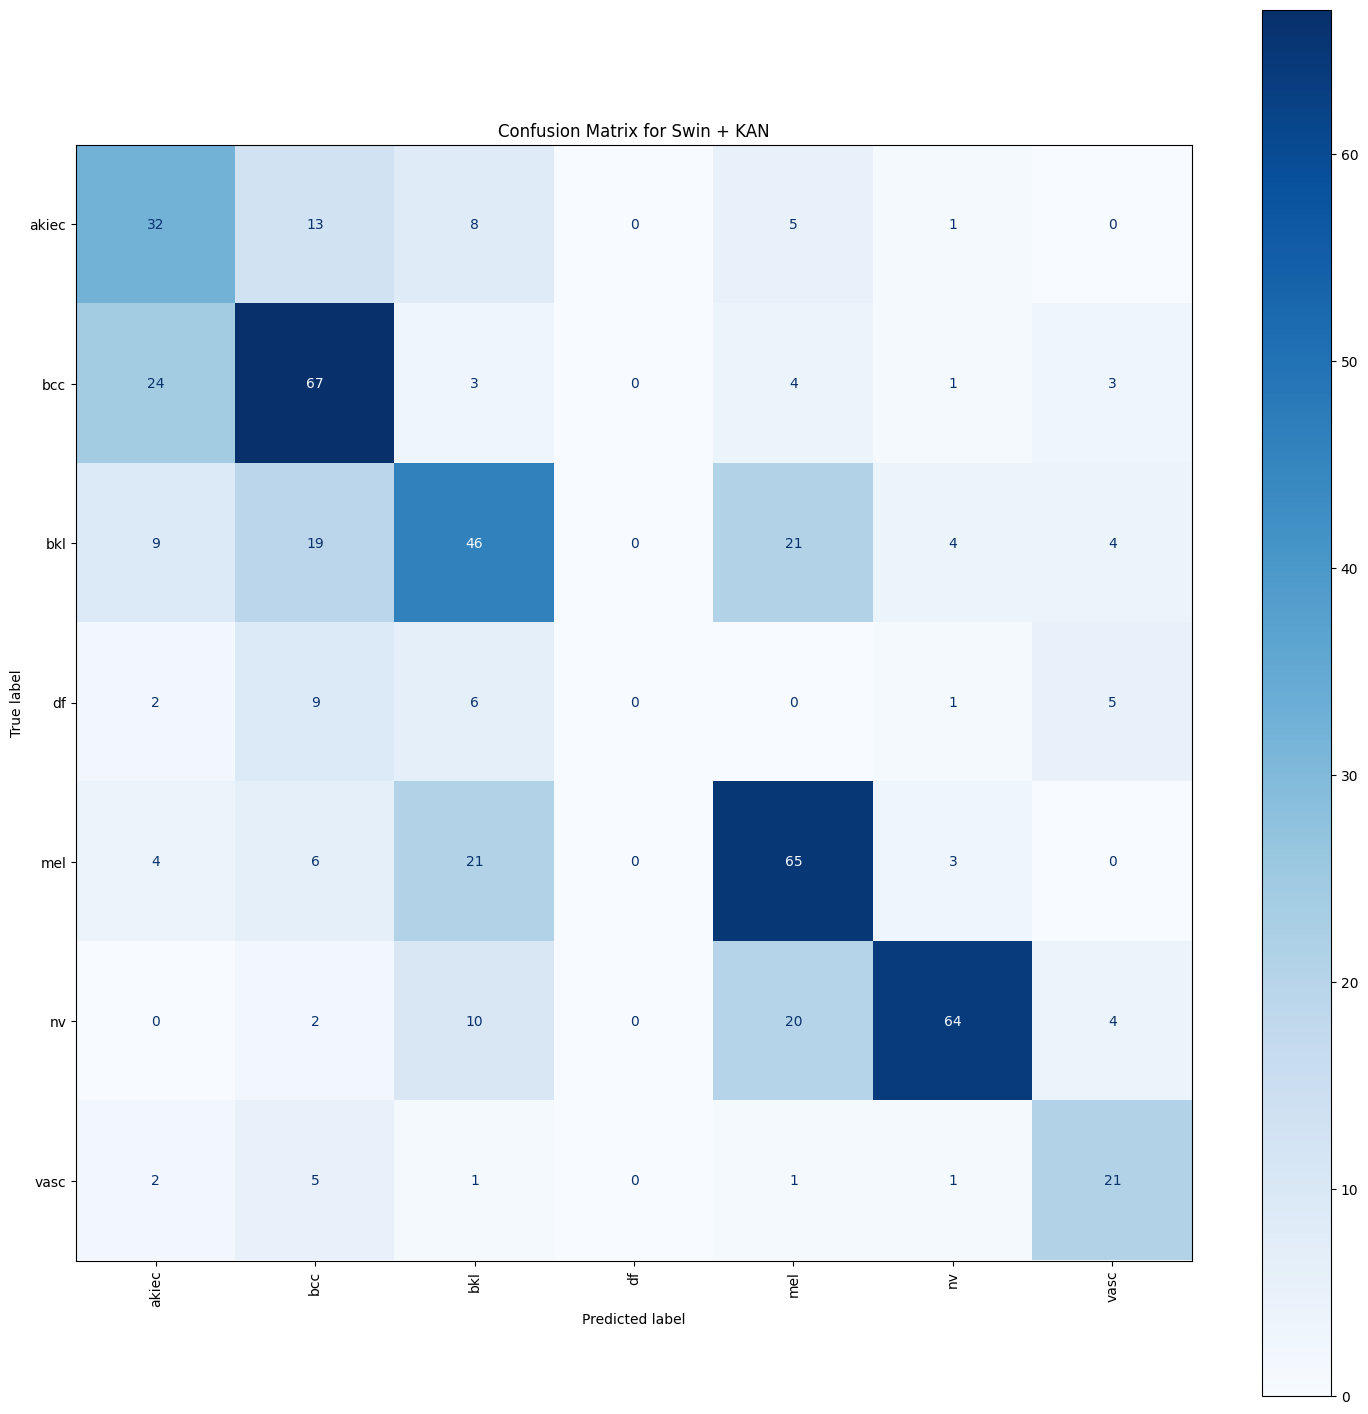

Image not found at /content/drive/MyDrive/candidiasis-large-skin-folds-175.jpeg, skipping example inference.
Script finished.


In [ ]:
# finetuneswin_with_KAN.py
# Colab-ready script that reproduces your original finetune pipeline but
# replaces Swin MLP's fc1 with KAN (spline correction) and runs a 2-stage fine-tune.
# Keeps dataset splitting, metrics, Trainer args, W&B logging, and evaluation identical
# to the original `finetuneswin.py` you provided. See original file for baseline. :contentReference[oaicite:1]{index=1}



# ====== Final evaluation & confusion matrix (same as baseline) ======
print("\nPerforming final evaluation on the unseen hold-out test set...")
results = trainer_stageB.evaluate(eval_dataset=processed_dataset["test"])
print("\n--- Final Test Set Metrics (KAN) ---")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test F1-Score: {results['eval_f1']:.4f}")
print("----------------------------\n")

print("Generating confusion matrix on the test set...")
predictions_output = trainer_stageB.predict(processed_dataset["test"])
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids
class_names = dataset["test"].features["label"].names

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix for Swin + KAN")
plt.show()

# ====== Inference example (same idea as baseline) ======
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image

MODEL_PATH = None  # optional: set to a saved checkpoint path if you want to load
IMAGE_PATH = "/content/drive/MyDrive/candidiasis-large-skin-folds-175.jpeg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if MODEL_PATH:
    print(f"Loading model from: {MODEL_PATH}")
    processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
    model = AutoModelForImageClassification.from_pretrained(MODEL_PATH).to(device)
else:
    processor = image_processor

try:
    image = Image.open(IMAGE_PATH).convert("RGB")
except FileNotFoundError:
    print(f"Image not found at {IMAGE_PATH}, skipping example inference.")
    image = None

if image is not None:
    inputs = processor(images=image, return_tensors="pt").to(device)
    model.to(device).eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]
    print("\n--- Prediction Result (KAN model) ---")
    print(f"The model predicts this image is: {predicted_class}")

print("Script finished.")


In [ ]:
# ====== Inference example (same idea as baseline) ======
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image

MODEL_PATH = None  # optional: set to a saved checkpoint path if you want to load
IMAGE_PATH = "/content/drive/MyDrive/skin_image.jpeg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if MODEL_PATH:
    print(f"Loading model from: {MODEL_PATH}")
    processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
    model = AutoModelForImageClassification.from_pretrained(MODEL_PATH).to(device)
else:
    processor = image_processor

try:
    image = Image.open(IMAGE_PATH).convert("RGB")
except FileNotFoundError:
    print(f"Image not found at {IMAGE_PATH}, skipping example inference.")
    image = None

if image is not None:
    inputs = processor(images=image, return_tensors="pt").to(device)
    model.to(device).eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]
    print("\n--- Prediction Result (KAN model) ---")
    print(f"The model predicts this image is: {predicted_class}")

print("Script finished.")


--- Prediction Result (KAN model) ---
The model predicts this image is: mel
Script finished.
